In [2]:
from torch import cuda
from datasets import load_dataset, DatasetDict, Dataset
from datasets import ClassLabel, Sequence
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification, pipeline
from evaluate import load
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import pandas as pd
from IPython.display import display, HTML
import ast
import logging

print("Impoted successfully")

Impoted successfully


In [3]:
# Désactivation des messages de codecarbon et de logs inutiles
logging.getLogger("codecarbon").setLevel(logging.ERROR)
print("Deactivated codecarbon logs successfully")

Deactivated codecarbon logs successfully


In [4]:
# Si seqeval n'est pas installé, il faut l'installer
try:
    import seqeval
except ImportError:
    print("seqeval non installé, vous devez exécuter 'pip install seqeval' pour l'installation")

device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
# **Définition des labels**
label_list = ["O", "B-DEP", "I-DEP", "B-ARR", "I-ARR"]

print("Labels defined successfully")

Labels defined successfully


In [6]:
# **Chargement du dataset**
path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/tokens/token.csv"
dataset = DatasetDict({'train': Dataset.from_dict({})})

print("Dataset loaded successfully")

Dataset loaded successfully


In [7]:
# **Chargement des fichiers CSV**
if os.path.isfile(path) and path.endswith(".csv"):
    new_data = load_dataset('csv', data_files=path, delimiter=';')
    dataset["train"] = new_data["train"]

print("CSV loaded successfully")

CSV loaded successfully


In [8]:
# **Nettoyage des colonnes inutiles**
dataset["train"] = dataset["train"].remove_columns("spacy_ner_tags")

print("Columns cleaned")

Columns cleaned


In [9]:
# **Fonction pour une évaluation sécurisée de la conversion des chaînes en listes**
def safe_literal_eval(value):
    """Tentative d'évaluation sécurisée d'une chaîne de caractères en liste"""
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return []  # Retourne une liste vide en cas d'erreur

# **Conversion des colonnes `tokens` et `ner_tags` en listes**
dataset = dataset.map(lambda line: {'tokens': safe_literal_eval(line['tokens'])})
dataset = dataset.map(lambda line: {'ner_tags': safe_literal_eval(line['ner_tags'])})

# **Casting des ner_tags en format Sequence[ClassLabel]**
dataset = dataset.cast_column("ner_tags", Sequence(feature=ClassLabel(num_classes=len(label_list), names=label_list)))

In [10]:
# **Affichage aléatoire des données**
def show_random_elements(dataset, num_examples=10):
    picks = random.sample(range(len(dataset)), num_examples)
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

show_random_elements(dataset["train"])

,text,tokens,ner_tags
0,Pourrais-tu m'indiquer comment aller d'Angers à Sainte-Pazanne,"[Pourrais-, tu, m', indiquer, comment, aller, d', Angers, à, Sainte-, Pazanne]","[O, O, O, O, O, O, O, B-DEP, O, B-ARR, I-ARR]"
1,Aller de l'hopital de DROUÉ (CENTRE) à ax-les-thermes.,"[Aller, de, l', hopital, de, DROUÉ, CENTRE), à, ax-, les-, thermes, .]","[O, O, O, O, O, B-DEP, I-DEP, O, B-ARR, I-ARR, I-ARR, O]"
2,Je veux me rendre chez mon ami Marie-Elsa qui habite à gramat en partant de LA FOREST LANDERNEAU,"[Je, veux, me, rendre, chez, mon, ami, Marie-, Elsa, qui, habite, à, gramat, en, partant, de, LA, FOREST, LANDERNEAU]","[O, O, O, O, O, O, O, O, O, O, O, O, B-ARR, O, O, O, B-DEP, I-DEP, I-DEP]"
3,"J’ai acheté des profiteroles, t’en veux ?","[J’, ai, acheté, des, profiteroles,, t’, en, veux, , .]","[O, O, O, O, O, O, O, O, O, O]"
4,Depuis la place centrale de Corbigny vers EYMOUTIERS.,"[Depuis, la, place, centrale, de, Corbigny, vers, EYMOUTIERS, .]","[O, O, O, O, O, B-DEP, O, B-ARR, O]"
5,Combien coûte un billet pour aller de CREIL à SAINT-PRIEST ?,"[Combien, coûte, un, billet, pour, aller, de, CREIL, à, SAINT-PRIEST, ?]","[O, O, O, O, O, O, O, B-DEP, O, I-DEP, O]"
6,Comment puis-je rejoindre COLOMIERS depuis Dinan ?,"[Comment, puis-, je, rejoindre, COLOMIERS, depuis, Dinan, , .]","[O, O, O, O, B-ARR, O, B-DEP, O, O]"
7,Je pars de l'hopital d'audun le roman vers l'hopital de étang sur arroux.,"[Je, pars, de, l', hopital, d', audun, le, roman, vers, l', hopital, de, étang, sur, arroux, .]","[O, O, O, O, O, O, B-DEP, I-DEP, I-DEP, O, O, O, O, B-ARR, I-ARR, I-ARR, O]"
8,Comment puis-je aller à EYSINES en venant de CHÂTEAUROUX ?,"[Comment, puis, -je, aller, à, EYSINES, en, venant, de, CHÂTEAUROUX, ?]","[O, O, O, O, O, I-DEP, O, O, O, B-DEP, O]"
9,"Je souhaite aller chez 1900 qui vit à BOULOGNE-BILLANCOURT, peux-tu m'aider à planifier le trajet depuis CHÂTEAUROUX ?","[Je, souhaite, aller, chez, 1900, qui, vit, à, BOULOGNE, -, BILLANCOURT, ,, peux, -, tu, m', aider, à, planifier, le, trajet, depuis, CHÂTEAUROUX, ?]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-DEP, O]"


In [11]:
# **Préparation du dataset**
train_data = dataset['train'].shuffle(seed=42)
train_test_valid = train_data.train_test_split(test_size=0.25)
test_valid = train_test_valid['test'].train_test_split(test_size=0.7)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

dataset_sample_size = 80000
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(min(dataset_sample_size, len(dataset["train"]))))
dataset["test"] = dataset["test"].shuffle(seed=42).select(range(min(dataset_sample_size // 10, len(dataset["test"]))))
dataset["valid"] = dataset["valid"].shuffle(seed=42).select(range(min(dataset_sample_size // 10, len(dataset["valid"]))))

In [12]:
# **Chargement du tokenizer**
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print("Tokenizer loaded successfully")

Tokenizer loaded successfully


C:\Users\vikne\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
# **Alignement des labels avec les tokens**
label_all_tokens = True
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [14]:
# **Préparation du modèle**
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in id2label.items()}

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# **Configuration du Trainer**
batch_size = 16  # Taille des batchs réduite
num_train_epochs = 2  # Réduction des époques à 2
args = TrainingArguments(
    "models/distilbert-finetuned-token-classification",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    save_total_limit=1,
    logging_steps=10,
    disable_tqdm=False,
    report_to="none",
    max_steps=500  # Limite du nombre total d'étapes
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load("seqeval")

C:\Users\vikne\anaconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    y_pred = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    y_true = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=y_pred, references=y_true)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# **Entraînement**
model_save_path = r"C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/distilbert"
trainer.save_model(model_save_path)
print(f"Model saved successfully at {model_save_path}")


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 1.0489, 'grad_norm': 2.0199179649353027, 'learning_rate': 2.94e-05, 'epoch': 0.0}
{'loss': 0.6733, 'grad_norm': 2.563279867172241, 'learning_rate': 2.88e-05, 'epoch': 0.0}
{'loss': 0.6082, 'grad_norm': 2.293996572494507, 'learning_rate': 2.8199999999999998e-05, 'epoch': 0.01}
{'loss': 0.5234, 'grad_norm': 1.7799097299575806, 'learning_rate': 2.7600000000000003e-05, 'epoch': 0.01}
{'loss': 0.4495, 'grad_norm': 1.9883365631103516, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.01}
{'loss': 0.4361, 'grad_norm': 2.3375275135040283, 'learning_rate': 2.64e-05, 'epoch': 0.01}
{'loss': 0.3738, 'grad_norm': 3.710632801055908, 'learning_rate': 2.58e-05, 'epoch': 0.01}
{'loss': 0.3279, 'grad_norm': 3.695059299468994, 'learning_rate': 2.52e-05, 'epoch': 0.02}
{'loss': 0.2934, 'grad_norm': 4.281088352203369, 'learning_rate': 2.4599999999999998e-05, 'epoch': 0.02}
{'loss': 0.2613, 'grad_norm': 2.30232310295105, 'learning_rate': 2.4e-05, 'epoch': 0.02}
{'loss': 0.2637, 'grad_norm': 3.61

  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.017534686252474785, 'eval_precision': 0.9816644678387766, 'eval_recall': 0.9859116843784647, 'eval_f1': 0.9837834920806239, 'eval_accuracy': 0.9954002735249374, 'eval_runtime': 321.7305, 'eval_samples_per_second': 24.866, 'eval_steps_per_second': 1.554, 'epoch': 0.1}
{'train_runtime': 1524.6091, 'train_samples_per_second': 5.247, 'train_steps_per_second': 0.328, 'train_loss': 0.14978178763389588, 'epoch': 0.1}


In [18]:
# **Évaluation et résultats**
train_metrics = trainer.evaluate(tokenized_datasets["train"])
validation_metrics = trainer.evaluate(tokenized_datasets["valid"])
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
# Extraction des résultats
predictions = np.argmax(predictions, axis=2)
y_pred = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
y_true = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

In [20]:
# Rapport de classification
flat_y_true = [item for sublist in y_true for item in sublist]
flat_y_pred = [item for sublist in y_pred for item in sublist]
print(classification_report(flat_y_true, flat_y_pred, labels=label_list))

              precision    recall  f1-score   support

           O       1.00      1.00      1.00    135844
       B-DEP       0.99      0.99      0.99     21054
       I-DEP       0.99      0.99      0.99     16990
       B-ARR       0.98      0.98      0.98     14113
       I-ARR       0.98      0.99      0.98      9903

    accuracy                           1.00    197904
   macro avg       0.99      0.99      0.99    197904
weighted avg       1.00      1.00      1.00    197904



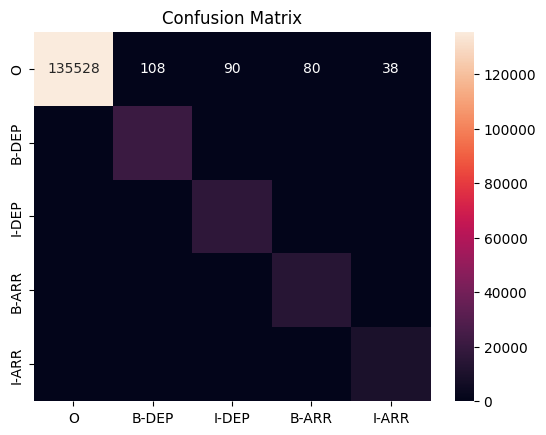

In [21]:
# Matrice de confusion
cm = confusion_matrix(flat_y_true, flat_y_pred, labels=label_list)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_list, yticklabels=label_list)
plt.title("Confusion Matrix")
plt.show()

In [22]:
# **Pipeline pour la prédiction**
sentences = [
    "Je pars de Paris et j'arrive à Marseille.",
    "Je vais à Bordeaux en partant de Toulouse.",
    "Mon trajet va de VILLIERS SUR LOIR à JARNY.",
    "Nous partons de Lyon et nous arrivons à Nice.",
    "Le départ est prévu à Lille, et l'arrivée se fera à Strasbourg.",
    "Mon itinéraire inclut un départ de Montpellier et une arrivée à Perpignan.",
    "Le train partira de Nantes pour arriver à Rennes.",
    "Un vol de Genève à Zurich est prévu demain matin.",
    "Je vais de Grenoble à Dijon en voiture.",
    "Je voyage de Bruxelles à Amsterdam ce week-end.",
    "L'itinéraire commence à Marseille et se termine à Toulon.",
    "Nous prenons un train de Rouen pour aller au Havre.",
    "Le départ sera à Limoges et l'arrivée à Poitiers.",
    "Je quitte Monaco pour aller à Menton.",
    "Le bus va de Caen à Cherbourg.",
    "Il part de Bayonne et arrive à Biarritz.",
    "Je vais de Chamonix à Annecy.",
    "Nous roulons de Bastia à Ajaccio.",
    "Le ferry part de Calais pour arriver à Douvres.",
    "Je pars de Bordeaux et j'arrive à Paris.",
]

token_classifier = pipeline("token-classification", model="models", aggregation_strategy="simple")

for sentence in sentences:
    outputs = token_classifier(sentence)
    print(sentence)
    print(outputs)

Je pars de Paris et j'arrive à Marseille.
[{'entity_group': 'DEP', 'score': 0.9958223, 'word': 'paris', 'start': 11, 'end': 16}, {'entity_group': 'ARR', 'score': 0.94282115, 'word': 'marseille', 'start': 31, 'end': 40}]
Je vais à Bordeaux en partant de Toulouse.
[{'entity_group': 'ARR', 'score': 0.990914, 'word': 'bordeaux', 'start': 10, 'end': 18}, {'entity_group': 'DEP', 'score': 0.99647933, 'word': 'toulouse', 'start': 33, 'end': 41}]
Mon trajet va de VILLIERS SUR LOIR à JARNY.
[{'entity_group': 'DEP', 'score': 0.9956783, 'word': 'villiers sur loir', 'start': 17, 'end': 34}, {'entity_group': 'ARR', 'score': 0.993932, 'word': 'jar', 'start': 37, 'end': 40}, {'entity_group': 'ARR', 'score': 0.99553406, 'word': '##ny', 'start': 40, 'end': 42}]
Nous partons de Lyon et nous arrivons à Nice.
[{'entity_group': 'DEP', 'score': 0.99780804, 'word': 'lyon', 'start': 16, 'end': 20}, {'entity_group': 'DEP', 'score': 0.6025036, 'word': '##rivons', 'start': 31, 'end': 37}, {'entity_group': 'ARR', 